In [48]:
library(Seurat)
library(org.Hs.eg.db)
library(clusterProfiler)
library(patchwork)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(ggpubr)
library(readr)
library(tidyr)
library(ggforce)
library(pals)
library(pheatmap)
library(scales)
library(ggthemes)
library(clustree)
library(ComplexHeatmap)
library(circlize)
library(ggrastr)
library(ggrepel)
library(viridis)
library(tibble)
library(igraph)

In [9]:
rdsjo <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240103_Integ.final_UMAP_Clean.rds")
rdsjo_meta <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240107_Integ.final.metadata.rds")
rdsjo@meta.data <- rdsjo_meta

In [15]:
setwd("/mnt/public3/chaohy/pancancer/fig4/")

In [4]:
filter_gene <- function(df, colName){
    mt_genes <- c("MT-ND1","MT-ND2","MT-CO1","MT-CO2","MT-ATP8","MT-ATP6","MT-CO3","MT-ND3","MT-ND4L","MT-ND4","MT-ND5","MT-ND6","MT-CYB",
                "HSALNG0136336","HSALNG0136337","HSALNG0136338","HSALNG0136339","HSALNG0136340","HSALNG0136341")
    blood_genes <- c("HBA1", "HBA2", "HBB", "HBM", "ALAS2")
    df <- dplyr::filter(df, !grepl("^RP[SL]", df[[colName]]))
    df <- df[!df[[colName]] %in% mt_genes,]
    df <- df[!df[[colName]] %in% blood_genes,]
    return(df)
}

In [5]:
all_markerGenes <- read.table("/mnt/public3/chaohy/pancancer/fig4/all_markerGenes.csv", header = T)
all_markerGenes[all_markerGenes$p_val_adj < 0.05,] %>% dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> all_markerGenes
all_markerGenes <- filter_gene(all_markerGenes, "gene") 
all_markerGenes <- all_markerGenes %>% group_by(cluster) %>% arrange(cluster, desc(pct.diff)) 
head(all_markerGenes)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,pct.diff,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
0,1.437590,0.726,0.304,0,HM,HSPA8,0.422,NA
0,2.499167,0.547,0.143,0,HM,HLA-B,0.404,NA
0,0.985588,0.639,0.249,0,HM,PTPRC,0.390,NA
0,1.018627,0.711,0.341,0,HM,HNRNPA2B1,0.370,NA
0,1.165669,0.466,0.113,0,HM,HSALNG0103881,0.353,HSALNG0103881
0,1.763978,0.546,0.198,0,HM,HSALNG0050644,0.348,HSALNG0050644


In [ ]:
avgExp0 <- AverageExpression(rdsjo, features = unique(all_markerGenes$gene), group.by = 'Course', assays = 'SCT')$SCT
markerExp <- t(apply(avgExp0, 1, scale))
colnames(markerExp) <- colnames(avgExp0)

png 
  2

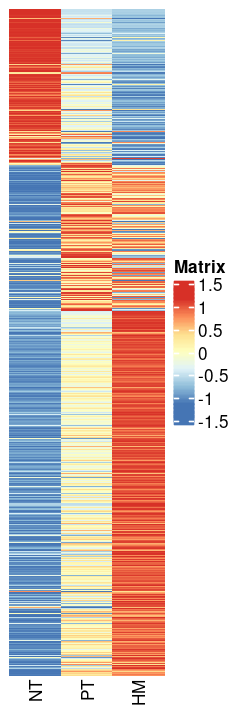

In [355]:
options(repr.plot.width = 2, repr.plot.height = 6)
# 获取当前列名的顺序
current_order <- colnames(markerExp)
new_order <- c("NT", "PT", "HM")
markerExp <- markerExp[, match(new_order, current_order)]

current_gene_order <- rownames(markerExp)
HM_gene_order <- all_markerGenes %>% dplyr::filter(cluster %in% "HM") %>% distinct(gene) %>% pull(gene)
PT_gene_order <- all_markerGenes %>% dplyr::filter(cluster %in% "PT") %>% distinct(gene) %>% pull(gene)
NT_gene_order <- all_markerGenes %>% dplyr::filter(cluster %in% "NT") %>% distinct(gene) %>% pull(gene)
new_gene_order <- c(NT_gene_order, PT_gene_order, HM_gene_order)
markerExp <- markerExp[match(new_gene_order, current_gene_order),]

# 绘制热图
pheatmap(markerExp, 
         border_color = NA, 
         cluster_cols = FALSE, 
         cluster_rows = FALSE, 
         show_colnames = TRUE, 
         show_rownames = FALSE, 
         main = "") -> pheat
pheat
pdf("/mnt/public3/chaohy/pancancer/fig4/fig4b1.pdf", width = 3, height = 10)
pheat
dev.off()

In [7]:
library(clusterProfiler)
library(fgsea)
library(org.Hs.eg.db)
library(xlsx)

In [8]:
head(all_markerGenes)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,pct.diff,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
0,1.437590,0.726,0.304,0,HM,HSPA8,0.422,NA
0,2.499167,0.547,0.143,0,HM,HLA-B,0.404,NA
0,0.985588,0.639,0.249,0,HM,PTPRC,0.390,NA
0,1.018627,0.711,0.341,0,HM,HNRNPA2B1,0.370,NA
0,1.165669,0.466,0.113,0,HM,HSALNG0103881,0.353,HSALNG0103881
0,1.763978,0.546,0.198,0,HM,HSALNG0050644,0.348,HSALNG0050644


In [9]:
log_thres <- 0

HM_markerGenes_FC <- all_markerGenes %>% dplyr::filter(cluster %in% "HM" & abs(avg_log2FC)>log_thres)
HM_markerGenes_pct <- HM_markerGenes_FC$pct.diff
names(HM_markerGenes_pct) <- HM_markerGenes_FC$gene
length(HM_markerGenes_pct)

PT_markerGenes_FC <- all_markerGenes %>% dplyr::filter(cluster %in% "PT" & abs(avg_log2FC)>log_thres)
PT_markerGenes_pct <- PT_markerGenes_FC$pct.diff
names(PT_markerGenes_pct) <- PT_markerGenes_FC$gene
length(PT_markerGenes_pct)

NT_markerGenes_FC <- all_markerGenes %>% dplyr::filter(cluster %in% "NT" & abs(avg_log2FC)>log_thres)
NT_markerGenes_pct <- NT_markerGenes_FC$pct.diff
names(NT_markerGenes_pct) <- NT_markerGenes_FC$gene
length(NT_markerGenes_pct)

[1] 1113

[1] 451

[1] 473

In [10]:
# hallmark <- gmtPathways("/mnt/public3/chaohy/pancancer/fig4/h.all.v2023.2.Hs.symbols.gmt")
hallmark <- gmtPathways("/mnt/public3/chaohy/pancancer/fig4/h.jo.all.v2023.2.Hs.symbols.gmt")
# hallmark <- gmtPathways("/mnt/public3/chaohy/pancancer/fig4/c5.go.bp.v2023.2.Hs.symbols.gmt")
# hallmark <- gmtPathways("/mnt/public3/chaohy/pancancer/fig4/h_and_C5.gmt")
HM_gsea <- fgsea(hallmark, HM_markerGenes_pct, minSize = 2, maxSize = 500, nproc = 4, scoreType = "pos", eps = 0.0)
HM_gsea = HM_gsea %>% arrange(desc(NES)) %>% dplyr::filter(pval<0.05 & NES > 1)

PT_gsea <- fgsea(hallmark, PT_markerGenes_pct, minSize = 2, maxSize = 500, nproc = 4, scoreType = "pos", eps = 0.0)
PT_gsea = PT_gsea %>% arrange(desc(NES)) %>% dplyr::filter(pval<0.05 & NES > 1)

NT_gsea <- fgsea(hallmark, NT_markerGenes_pct, minSize = 2, maxSize = 500, nproc = 4, scoreType = "pos", eps = 0.0)
NT_gsea = NT_gsea %>% arrange(desc(NES)) %>% dplyr::filter( NES > 1)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (79.87% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (67.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (44.61% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [369]:
head(HM_gsea,10)
head(PT_gsea,10)
head(NT_gsea,10)


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
EPITHELIAL_MESENCHYMAL_TRANSITION,9.848461e-04,0.011571942,0.4550599,0.5178752,2.171558,21,"TNFAIP3, GADD45B, EMP3 , TGFB1 , FLNA , IL32 , TPM4 , GLIPR1 , WIPF1 , CXCL8 , CD44 , AREG , CAPG , ITGB1 , JUN"
ALLOGRAFT_REJECTION,1.530411e-04,0.003596466,0.5188481,0.4379031,2.164605,45,"PTPRC, IL2RG, HLA-A, FYB1 , ITGB2, LCP2 , TGFB1, HLA-E, CD3D , LTB , SOCS1, FLNA , CD2 , CCL5 , CD3G , SRGN , HCLS1, CSK , ETS1 , GPR65, CD7 , GZMA , CAPG , CCL4 , B2M , CD247, WAS , LCK"
KRAS_SIGNALING_UP,6.457014e-04,0.010115988,0.4772708,0.5038763,2.153743,23,"LCP1 , CD37 , TNFAIP3 , IL2RG , LAPTM5 , IL7R , PPP1R15A, ITGB2 , CXCR4 , IKZF1 , ETS1 , PSMB8"
TNFA_SIGNALING_VIA_NFKB,3.058893e-05,0.001437680,0.5573322,0.4047202,2.141350,68,"DUSP2 , TNFAIP3 , FOSB , NR4A2 , CD69 , IRF1 , IER5 , GADD45B , KLF2 , IL7R , IER2 , PPP1R15A, CCNL1 , CD83 , KLF6 , BTG2 , MCL1 , REL , PTGER4 , PNRC1 , CCL5 , TNFAIP8 , KDM6B , SLC2A3 , ATF3 , CD44 , MAP3K8 , AREG , NR4A1 , SQSTM1 , NFKB1 , CCL4 , TIPARP , DUSP5"
IL6_JAK_STAT3_SIGNALING,1.262919e-02,0.118714385,0.3807304,0.4854303,1.905234,16,"IL2RG , IRF1 , TGFB1 , GRB2 , LTB , SOCS1 , CD44 , MAP3K8 , ITGA4 , JUN , TNFRSF1B"
HYPOXIA,3.796204e-02,0.273892774,0.2311267,0.3372193,1.607776,38,"TNFAIP3 , S100A4 , PPP1R15A, PGK1 , CITED2 , KLF6 , PNRC1 , IDS , CXCR4 , ISG20 , PLIN2 , ETS1 , SLC2A3 , ATF3 , TIPARP , HSPA5 , DDIT3 , JUN , NR3C1 , CDKN1A"
INFLAMMATORY_RESPONSE,4.195804e-02,0.273892774,0.2192503,0.3407902,1.586671,34,"CD69 , IRF1 , IL7R , EMP3 , LCP2 , KLF6 , BTG2 , PTGER4 , CCL5 , CD48 , CXCL8 , RHOG , NFKB1 , IL10RA , LCK , TNFRSF1B, CD55 , CDKN1A , HIF1A , LY6E , PDE4B"
MTORC1_SIGNALING,4.695305e-02,0.273892774,0.2065879,0.3137908,1.545701,44,"CORO1A , PPIA , PPP1R15A, ITGB2 , HSPD1 , PGK1 , BTG2 , TUBA4A , CACYBP , CXCR4 , CTSC , M6PR , SLA , ACTR3 , IDI1 , SLC2A3 , SQSTM1 , HSPA5 , CCT6A , DDIT3"


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
ANGIOGENESIS,6.373604e-05,0.002740650,0.5384341,0.8911083,2.183292,5,"S100A4, COL3A1, LUM , TIMP1"
EPITHELIAL_MESENCHYMAL_TRANSITION,1.326360e-04,0.002851674,0.5188481,0.6158675,1.961018,25,"COL3A1, COL1A2, COL1A1, NNMT , PLAUR , LUM , FN1 , ACTA2 , TPM2 , TIMP1 , LGALS1"
MYOGENESIS,6.952814e-03,0.074742749,0.4070179,0.6978660,1.842720,8,"COL3A1 , COL1A1 , TPM2 , BHLHE40, LSP1 , SPARC"
UV_RESPONSE_DN,1.218082e-02,0.088596368,0.3807304,0.6766261,1.786636,8,"COL3A1 , COL1A2 , COL1A1 , BHLHE40"
COMPLEMENT,3.533320e-03,0.050644251,0.4317077,0.5533173,1.728921,22,"PLAUR , S100A9, LGALS3, FN1 , CTSB , TIMP1 , CTSS , CTSC , CD55 , PSMB9"
ESTROGEN_RESPONSE_EARLY,2.448194e-02,0.119325119,0.3524879,0.6035932,1.646229,10,"TFF1 , NBL1 , MUC1 , KRT19 , BHLHE40, PLAAT3 , IGFBP4"
KRAS_SIGNALING_UP,1.382484e-02,0.088596368,0.3807304,0.5804484,1.632535,12,"PLAUR , CXCR4 , LAPTM5 , CTSS , TMEM176B, ERO1A , LCP1 , CD37 , IL2RG , EMP1 , PSMB8"
APICAL_JUNCTION,2.497502e-02,0.119325119,0.2878571,0.5365322,1.593512,16,"VASP , CAP1 , ACTN1, SKAP2, ARPC2, MDK , CNN2 , MSN , PFN1 , PTPRC, CD99 , FYB1"
HYPOXIA,1.442266e-02,0.088596368,0.3807304,0.5047458,1.585740,23,"S100A4 , LDHA , PLAUR , CXCR4 , ISG20 , BHLHE40, FOSL2 , ENO1 , ERO1A , IDS , DDIT4"


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
PANCREAS_BETA_CELLS,0.03531962,0.8281319,0.32177592,0.9247396,1.752783,2,"INS , SRP14"
KRAS_SIGNALING_DN,0.04995005,0.8281319,0.19991523,0.6639344,1.382373,11,"CLPS , CPB1 , GP2 , CPA2 , SELENOP, FGFR3 , FGGY , ZBTB16"
MTORC1_SIGNALING,0.23876124,0.8281319,0.08152651,0.6965875,1.312674,3,"PHGDH , SLC37A4"
SPERMATOGENESIS,0.27072927,0.8281319,0.07492788,0.6798182,1.281073,3,"CFTR , PEBP1"
MYOGENESIS,0.17182817,0.8281319,0.10027911,0.5920657,1.232735,11,"CLU , IGFBP7, CNN3 , APP , WWTR1"
COMPLEMENT,0.19380619,0.8281319,0.09314546,0.6053715,1.220658,8,"CLU , SERPING1, CD59 , S100A13 , CA2 , KLK1 , CD36"
ANGIOGENESIS,0.31568432,0.8281319,0.06720651,0.6342763,1.212327,4,"SERPINA5, APP , VTN , NRP1"
CHOLESTEROL_HOMEOSTASIS,0.30969031,0.8281319,0.06815134,0.6176880,1.197661,5,"CLU , FABP5 , ERRFI1"
INTERFERON_GAMMA_RESPONSE,0.35264735,0.8281319,0.06184060,0.6350156,1.196645,3,"SERPING1, MT2A , IFITM3"


In [278]:
HM_gsea_filtered <- HM_gsea[c(1,3,4,5,6,7),]
PT_gsea_filtered <- PT_gsea[c(1,2,3,5,7),]
NT_gsea_filtered <- NT_gsea[c(1,2),]
HM_gsea_filtered
PT_gsea_filtered
NT_gsea_filtered

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
EPITHELIAL_MESENCHYMAL_TRANSITION,9.848461e-04,0.01157194,0.4550599,0.5178752,2.171558,21,"TNFAIP3, GADD45B, EMP3 , TGFB1 , FLNA , IL32 , TPM4 , GLIPR1 , WIPF1 , CXCL8 , CD44 , AREG , CAPG , ITGB1 , JUN"
KRAS_SIGNALING_UP,6.457014e-04,0.01011599,0.4772708,0.5038763,2.153743,23,"LCP1 , CD37 , TNFAIP3 , IL2RG , LAPTM5 , IL7R , PPP1R15A, ITGB2 , CXCR4 , IKZF1 , ETS1 , PSMB8"
TNFA_SIGNALING_VIA_NFKB,3.058893e-05,0.00143768,0.5573322,0.4047202,2.141350,68,"DUSP2 , TNFAIP3 , FOSB , NR4A2 , CD69 , IRF1 , IER5 , GADD45B , KLF2 , IL7R , IER2 , PPP1R15A, CCNL1 , CD83 , KLF6 , BTG2 , MCL1 , REL , PTGER4 , PNRC1 , CCL5 , TNFAIP8 , KDM6B , SLC2A3 , ATF3 , CD44 , MAP3K8 , AREG , NR4A1 , SQSTM1 , NFKB1 , CCL4 , TIPARP , DUSP5"
IL6_JAK_STAT3_SIGNALING,1.262919e-02,0.11871438,0.3807304,0.4854303,1.905234,16,"IL2RG , IRF1 , TGFB1 , GRB2 , LTB , SOCS1 , CD44 , MAP3K8 , ITGA4 , JUN , TNFRSF1B"
HYPOXIA,3.796204e-02,0.27389277,0.2311267,0.3372193,1.607776,38,"TNFAIP3 , S100A4 , PPP1R15A, PGK1 , CITED2 , KLF6 , PNRC1 , IDS , CXCR4 , ISG20 , PLIN2 , ETS1 , SLC2A3 , ATF3 , TIPARP , HSPA5 , DDIT3 , JUN , NR3C1 , CDKN1A"
INFLAMMATORY_RESPONSE,4.195804e-02,0.27389277,0.2192503,0.3407902,1.586671,34,"CD69 , IRF1 , IL7R , EMP3 , LCP2 , KLF6 , BTG2 , PTGER4 , CCL5 , CD48 , CXCL8 , RHOG , NFKB1 , IL10RA , LCK , TNFRSF1B, CD55 , CDKN1A , HIF1A , LY6E , PDE4B"


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
ANGIOGENESIS,6.373604e-05,0.002740650,0.5384341,0.8911083,2.183292,5,"S100A4, COL3A1, LUM , TIMP1"
EPITHELIAL_MESENCHYMAL_TRANSITION,1.326360e-04,0.002851674,0.5188481,0.6158675,1.961018,25,"COL3A1, COL1A2, COL1A1, NNMT , PLAUR , LUM , FN1 , ACTA2 , TPM2 , TIMP1 , LGALS1"
MYOGENESIS,6.952814e-03,0.074742749,0.4070179,0.6978660,1.842720,8,"COL3A1 , COL1A1 , TPM2 , BHLHE40, LSP1 , SPARC"
COMPLEMENT,3.533320e-03,0.050644251,0.4317077,0.5533173,1.728921,22,"PLAUR , S100A9, LGALS3, FN1 , CTSB , TIMP1 , CTSS , CTSC , CD55 , PSMB9"
KRAS_SIGNALING_UP,1.382484e-02,0.088596368,0.3807304,0.5804484,1.632535,12,"PLAUR , CXCR4 , LAPTM5 , CTSS , TMEM176B, ERO1A , LCP1 , CD37 , IL2RG , EMP1 , PSMB8"


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
PANCREAS_BETA_CELLS,0.03531962,0.8281319,0.3217759,0.9247396,1.752783,2,"INS , SRP14"
KRAS_SIGNALING_DN,0.04995005,0.8281319,0.1999152,0.6639344,1.382373,11,"CLPS , CPB1 , GP2 , CPA2 , SELENOP, FGFR3 , FGGY , ZBTB16"


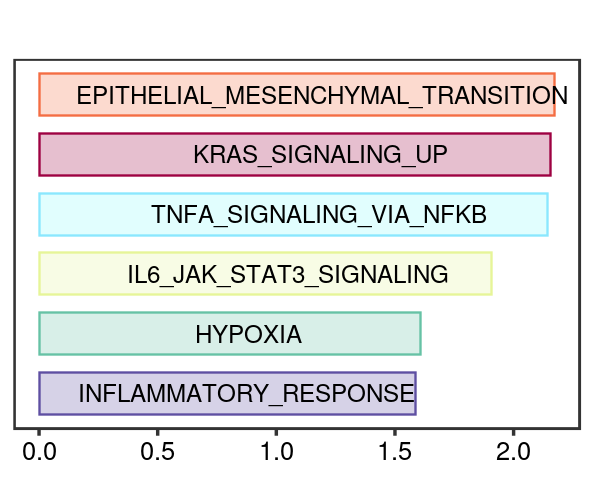

In [347]:
options(repr.plot.width=5, repr.plot.height=4)
HM_gsea_filtered$pathway <- factor(HM_gsea_filtered$pathway, levels = rev(HM_gsea_filtered$pathway))
ggplot(HM_gsea_filtered, aes(x = NES, y = pathway)) +
  geom_bar(stat = "identity", fill = c("#fcdacf","#e6bfcf","#e1fefe","#f8fce5","#d8efe8","#d6d2e7"),
           color=c("#f46d43","#9e0142","#8be7fe","#e6f598","#66c2a5","#5e4fa2"),
           width = 0.7) +
  geom_text(aes(label = pathway), position = position_stack(0.55), size = 5) +
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "NES", y = "Hallmark pathway", title = "") +
  guides(size = FALSE) +
  theme(axis.text = element_text(size = 15, color = "black"),
        axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank())  -> p1
p1

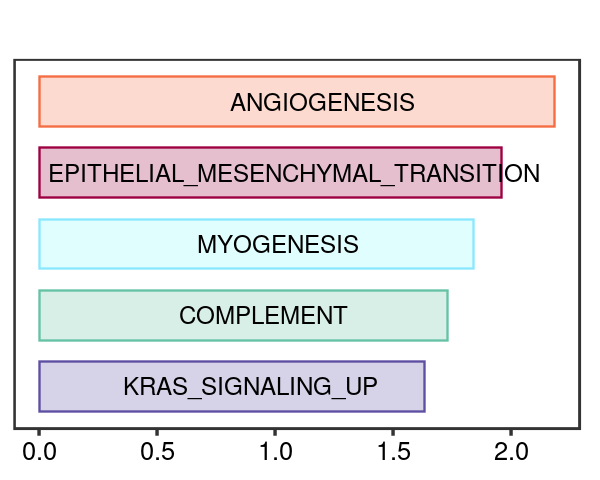

In [348]:
options(repr.plot.width=5, repr.plot.height=4)
PT_gsea_filtered$pathway <- factor(PT_gsea_filtered$pathway, levels = rev(PT_gsea_filtered$pathway))
ggplot(PT_gsea_filtered, aes(x = NES, y = pathway)) +
  geom_bar(stat = "identity", fill = c("#fcdacf","#e6bfcf","#e1fefe","#d8efe8","#d6d2e7"),
                              color=c("#f46d43","#9e0142","#8be7fe","#66c2a5","#5e4fa2"),
                              width = 0.7) +
  geom_text(aes(label = pathway), position = position_stack(0.55), size = 5)+
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "NES", y = "Hallmark pathway", title = "") +
  guides(size = FALSE)+
  theme(axis.text = element_text(size = 15, color = "black"),
        axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank())  -> p2
p2

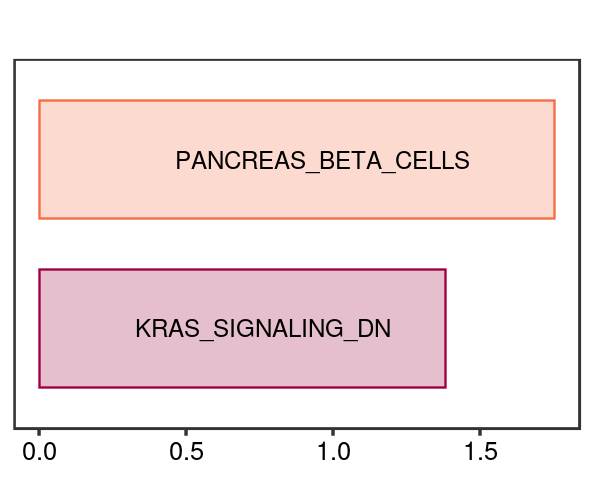

In [349]:
options(repr.plot.width=5, repr.plot.height=4)
NT_gsea_filtered$pathway <- factor(NT_gsea_filtered$pathway, levels = rev(NT_gsea_filtered$pathway))
ggplot(NT_gsea_filtered, aes(x = NES, y = pathway)) +
  geom_bar(stat = "identity", fill = c("#fcdacf","#e6bfcf"),
                              color=c("#f46d43","#9e0142"),
                              width = 0.7) +
  geom_text(aes(label = pathway), position = position_stack(0.55), size = 5)+
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "NES", y = "Hallmark pathway", title = "") +
  guides(size = FALSE)+
  theme(axis.text = element_text(size = 15, color = "black"),
        axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank())  -> p3
p3

png 
  2

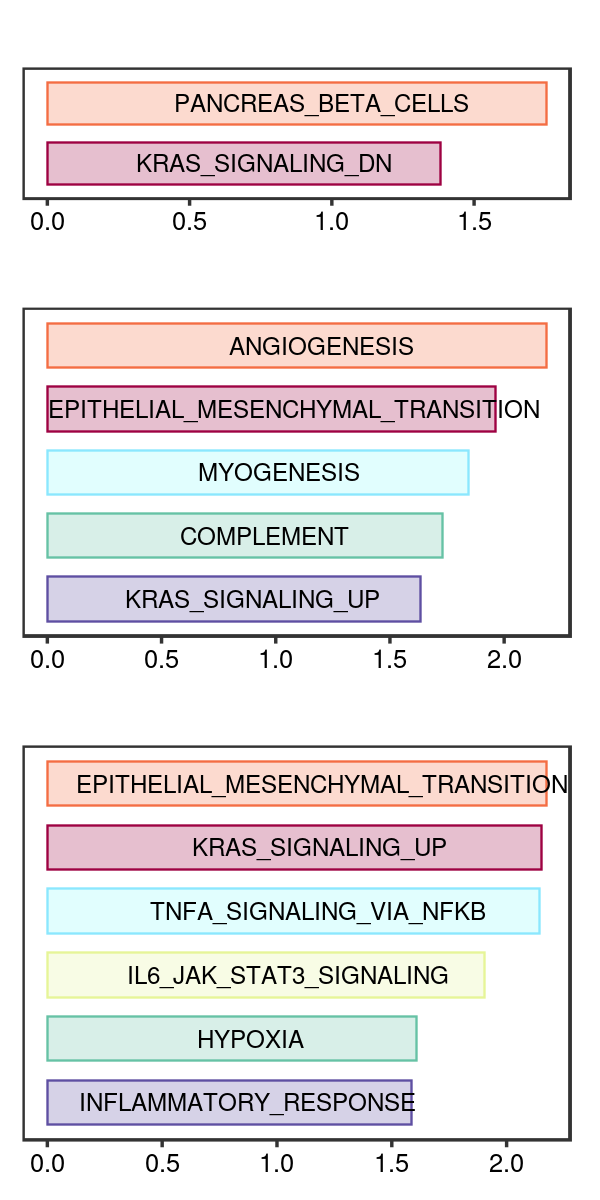

In [356]:
options(repr.plot.width=5, repr.plot.height=10)
(p3/p2/p1) + plot_layout(heights = c(0.4,1,1.2))

pdf("/mnt/public3/chaohy/pancancer/fig4/fig4b2.pdf", width = 5, height = 10)
(p3/p2/p1) + plot_layout(heights = c(0.4,1,1.2))
dev.off()


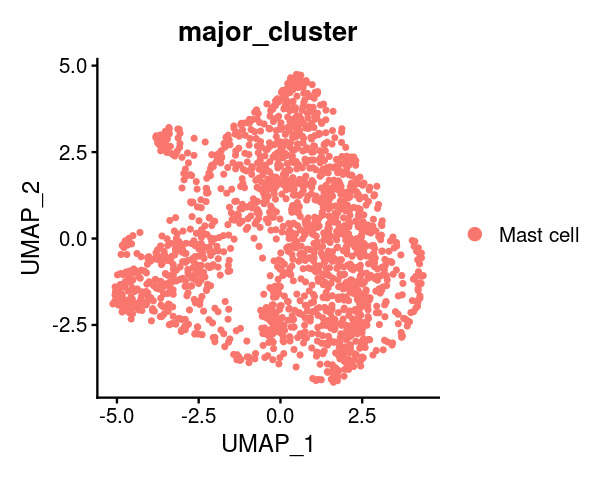

In [397]:
options(repr.plot.width=5, repr.plot.height=4)
DimPlot(NK,group.by = "major_cluster")

In [389]:
colors_jo <- read.table("/mnt/public3/chaohy/pancancer/plot1cell/colors_jo.txt", sep="\t", header=T,comment.char = "")
colors_jo$major_cluster <- factor(colors_jo$major_cluster,levels = colors_jo$major_cluster)
major_cluster_color = setNames(colors_jo$major_color, names(table(colors_jo$major_cluster)))
major_cluster_color

Ductal cell 1     Ductal cell 2     Ductal cell 3     Ductal cell 4 
        "#932437"         "#D5606B"         "#B22936"         "#B44250" 
    Ductal cell 5     Ductal cell 6     Acinar cell 1     Acinar cell 2 
        "#73001F"         "#D37E86"         "#F07E4C"         "#F8766D" 
   Endocrine cell     Stellate cell       EC arterial         EC venous 
        "#E6B8BF"         "#A883E7"         "#BB941B"         "#725500" 
     EC capillary             myCAF              iCAF             apCAF 
        "#967400"         "#CEC0E6"         "#EBCBF4"         "#9E7EE7" 
      Hepatocytes         Mast cell                DC          Monocyte 
        "#843B39"         "#7F7F7F"         "#009261"         "#ACC691" 
       Macrophage        Neutrophil               NKT                NK 
        "#53990F"         "#E5F7D2"         "#D5F4FF"         "#71B7F5" 
           CD4+ T            CD8+ T              Treg          MKI67+ T 
        "#527ABF"         "#3082BC"         "#095991"         "#075993" 
          Naive B          Memory B Dividing plasma B       Plasma cell 
        "#FFE6B2"         "#FFD09E"         "#FFF7D0"         "#FFB799"

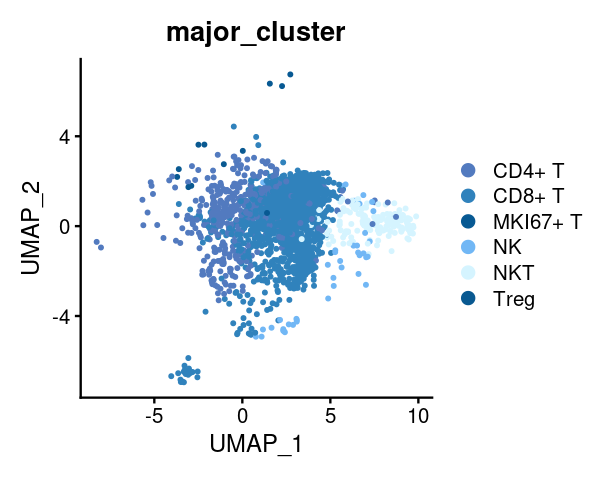

In [390]:
# 取出NT的细胞
NK_NT <- NK@meta.data %>% dplyr::filter(as.character(Course) %in% c('NT')) %>% rownames()
NK_NT <- subset(NK, cells=NK_NT)
DimPlot(NK_NT,group.by = "major_cluster",cols = major_cluster_color)

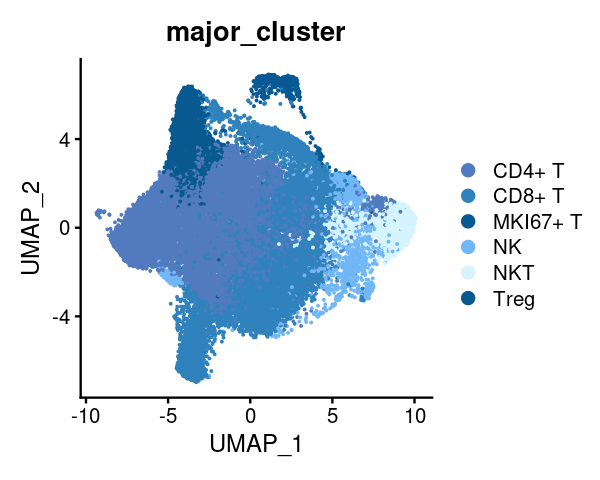

In [392]:
# 取出PT的细胞
NK_PT <- NK@meta.data %>% dplyr::filter(as.character(Course) %in% c('PT')) %>% rownames()
NK_PT <- subset(NK, cells=NK_PT)
DimPlot(NK_PT,group.by = "major_cluster",cols = major_cluster_color)

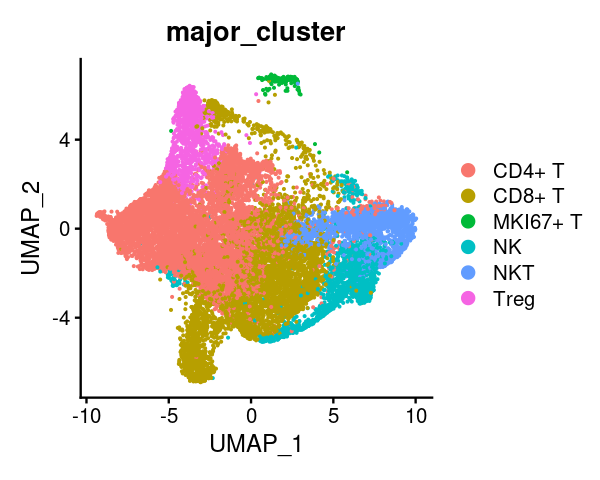

In [386]:
# 取出HM的细胞
NK_HM <- NK@meta.data %>% dplyr::filter(as.character(Course) %in% c('HM')) %>% rownames()
NK_HM <- subset(NK, cells=NK_HM)
DimPlot(NK_HM,group.by = "major_cluster",cols = major_cluster_color)

# scenic

In [16]:
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
filter_gene(gene_bed, "V4") -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC

In [17]:
nt_tf <- c("NR5A2","PDX1","SOX17","EGR1","TFDP2","ZNF22","ZNF740","ERG","FOXP1","SOX18")
pt_tf <- c("FLI1","KLF3","SP3","E2F3","FOXP1","SP1","KLF10","CTCF","EGR3","KLF6")
hm_tf <- c("KLF12","KLF6","PBX4","ETV5","E2F1","FLI1","ZNF100","KLF16","KLF10","E2F3")

In [18]:
library(data.table)
s2 <- fread("/mnt/public3/chaohy/pancancer/fig4/s2.adj.tsv",sep = "\t",header = T)

In [19]:
importance_threshold <- 10
nt_tf_tg <- s2 %>% dplyr::filter(TF %in% nt_tf & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF) 
dim(nt_tf_tg)
pt_tf_tg <- s2 %>% dplyr::filter(TF %in% pt_tf & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF)
dim(pt_tf_tg)
hm_tf_tg <- s2 %>% dplyr::filter(TF %in% hm_tf & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF)
dim(hm_tf_tg)

[1] 5278    3

[1] 1569    3

[1] 1060    3

In [20]:
nt_tf_tg$type <- ifelse(nt_tf_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
pt_tf_tg$type <- ifelse(pt_tf_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
hm_tf_tg$type <- ifelse(hm_tf_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
head(hm_tf_tg)

TF,target,importance,type
<chr>,<chr>,<dbl>,<chr>
E2F1,CDT1,85.39697,mRNA
E2F1,GINS2,85.15932,mRNA
E2F1,MCM4,78.18927,mRNA
E2F1,UHRF1,75.38603,mRNA
E2F1,MCM2,68.93502,mRNA
E2F1,DTL,67.02604,mRNA


In [21]:
hm_df <- table(hm_tf_tg$TF,hm_tf_tg$type) %>% as.data.frame.matrix() %>% rownames_to_column("TF") %>% mutate(course = "HM") %>% select(course, everything())
hm_df$Count <- rowSums(hm_df[,3:4])

nt_df <- table(nt_tf_tg$TF,nt_tf_tg$type) %>% as.data.frame.matrix() %>% rownames_to_column("TF") %>% mutate(course = "NT") %>% select(course, everything())
nt_df$Count <- rowSums(nt_df[,3:4])

pt_df <- table(pt_tf_tg$TF,pt_tf_tg$type) %>% as.data.frame.matrix() %>% rownames_to_column("TF") %>% mutate(course = "PT") %>% select(course, everything())
pt_df$Count <- rowSums(pt_df[,3:4])

rbind(hm_df,nt_df,pt_df) -> cs_tf_tg_df
dim(cs_tf_tg_df)
head(cs_tf_tg_df)

[1] 30  5

,course,TF,lncRNA,mRNA,Count
,<chr>,<chr>,<int>,<int>,<dbl>
1,HM,E2F1,0,90,90
2,HM,E2F3,13,1,14
3,HM,ETV5,1,2,3
4,HM,FLI1,14,215,229
5,HM,KLF10,5,17,22
6,HM,KLF12,3,4,7


In [22]:
nodes <- unique(c(cs_tf_tg_df$TF, cs_tf_tg_df$course)) # 此处注意nodes名字的顺序，要和下面的饼图中的pie_df一定要对应
nodes <- mutate(data.frame(nodes), id = 1:length(nodes)) # 可以为点添加各种属性
colnames(nodes)<-c("label","location")

edges <- cs_tf_tg_df[, c(1,2,5)]

# 构建饼图列表
pie_df <- rbind(cs_tf_tg_df[, c(2,3,4)],c("HM","1","0"),c("NT","1","0"),c("PT","1","0")) %>% distinct(TF, .keep_all = TRUE)
result_list <- lapply(1:nrow(pie_df), function(i) as.numeric(c(pie_df[i, "lncRNA"], pie_df[i, "mRNA"])))
names(result_list) <- pie_df$TF

# 构建节点大小列表
node_size <- c(cs_tf_tg_df %>% distinct(TF, .keep_all = TRUE) %>% pull(Count),1000,1000,1000)
names(node_size) <- c(cs_tf_tg_df %>% distinct(TF, .keep_all = TRUE) %>% pull(TF),"HM","NT","PT")

In [26]:
# 创建一个igraph对象
net_pc<-graph_from_data_frame(
   d=edges,
   vertices=nodes,
   directed=TRUE)
net_pc

IGRAPH ff16bf1 DN-- 28 30 -- 
+ attr: name (v/c), location (v/n), Count (e/n)
+ edges from ff16bf1 (vertex names):
 [1] HM->E2F1   HM->E2F3   HM->ETV5   HM->FLI1   HM->KLF10  HM->KLF12 
 [7] HM->KLF16  HM->KLF6   HM->PBX4   HM->ZNF100 NT->EGR1   NT->ERG   
[13] NT->FOXP1  NT->NR5A2  NT->PDX1   NT->SOX17  NT->SOX18  NT->TFDP2 
[19] NT->ZNF22  NT->ZNF740 PT->CTCF   PT->E2F3   PT->EGR3   PT->FLI1  
[25] PT->FOXP1  PT->KLF10  PT->KLF3   PT->KLF6   PT->SP1    PT->SP3   

png 
  2

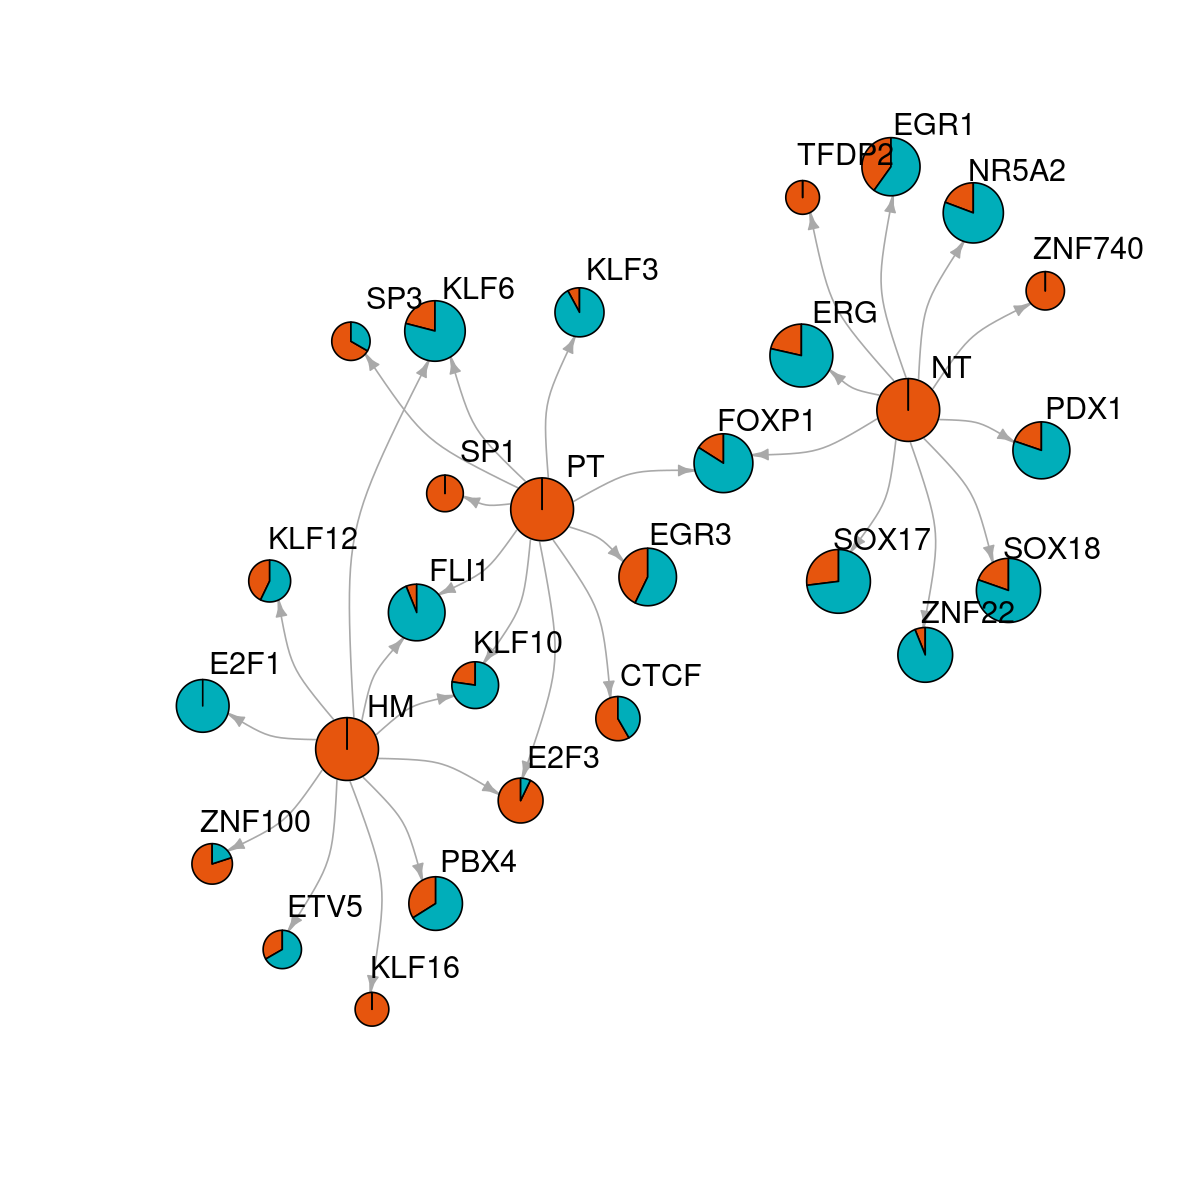

In [28]:
options(repr.plot.width=10, repr.plot.height=10)
pdf("/mnt/public3/chaohy/pancancer/fig4/fig4e.pdf", width = 10, height = 10)
plot(net_pc,
    vertex.size=log(node_size)+8, # 节点的大小
    vertex.label.cex=1.5, # 节点标签的字体大小
    vertex.label.color="black", # 节点标签的颜色
    vertex.label.dist=2, # 设置节点标签和点的距离
    edge.arrow.size=.4, # 设置箭头的大小
    edge.curved=.3, # 设置边的弯曲程度
    layout=layout_with_dh(net_pc), # 设置图形的布局
    vertex.shape="pie", # 节点的形状
    vertex.pie=result_list, # 节点的饼图数据
    vertex.pie.color=list(c("#e6550d", "#00aeba")))
dev.off()        
# 添加图例
# legend(x=-1.5,y=1.5,levels(factor(V(net_pc)$location)),pch=21,col="#777777")

plot(net_pc,
    vertex.size=log(node_size)+8, # 节点的大小
    vertex.label.cex=1.5, # 节点标签的字体大小
    vertex.label.color="black", # 节点标签的颜色
    vertex.label.dist=2, # 设置节点标签和点的距离
    edge.arrow.size=.4, # 设置箭头的大小
    edge.curved=.3, # 设置边的弯曲程度
    layout=layout_with_dh(net_pc), # 设置图形的布局
    vertex.shape="pie", # 节点的形状
    vertex.pie=result_list, # 节点的饼图数据
    vertex.pie.color=list(c("#e6550d", "#00aeba")))

In [61]:
nt_tf_uniq <- c("NR5A2","PDX1","SOX17","EGR1","TFDP2","ZNF22","ZNF740","ERG","SOX18")
pt_tf_uniq <- c("KLF3","SP3","SP1","CTCF","EGR3")
hm_tf_uniq <- c("KLF12","PBX4","ETV5","E2F1","ZNF100","KLF16")

In [66]:
importance_threshold <- 10
nt_tf_uniq_tg <- s2 %>% dplyr::filter(TF %in% nt_tf_uniq & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF) %>% top_frac(0.05, importance) %>% as.data.frame()
filter_gene(nt_tf_uniq_tg, "target") -> nt_tf_uniq_tg
colnames(nt_tf_uniq_tg) <- c("source","target","Weight")
dim(nt_tf_uniq_tg)
write.csv(nt_tf_uniq_tg, "/mnt/public3/chaohy/pancancer/fig4/nt.edge.csv", row.names = F)

pt_tf_uniq_tg <- s2 %>% dplyr::filter(TF %in% pt_tf_uniq & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF) %>% as.data.frame()
filter_gene(pt_tf_uniq_tg, "target") -> pt_tf_uniq_tg
colnames(pt_tf_uniq_tg) <- c("source","target","Weight")
dim(pt_tf_uniq_tg)
write.csv(pt_tf_uniq_tg, "/mnt/public3/chaohy/pancancer/fig4/pt.edge.csv", row.names = F)

hm_tf_uniq_tg <- s2 %>% dplyr::filter(TF %in% hm_tf_uniq & importance > importance_threshold) %>% arrange(TF) %>% group_by(TF) %>% as.data.frame()
filter_gene(hm_tf_uniq_tg, "target") -> hm_tf_uniq_tg
colnames(hm_tf_uniq_tg) <- c("source","target","Weight")
dim(hm_tf_uniq_tg)
write.csv(hm_tf_uniq_tg, "/mnt/public3/chaohy/pancancer/fig4/hm.edge.csv", row.names = F)


[1] 230   3

[1] 333   3

[1] 217   3

In [67]:
nt_tf_uniq_tg$annotation <- ifelse(nt_tf_uniq_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
pt_tf_uniq_tg$annotation <- ifelse(pt_tf_uniq_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
hm_tf_uniq_tg$annotation <- ifelse(hm_tf_uniq_tg$target %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")

nt_tf_uniq_tg %>% filter(annotation == "lncRNA") %>% group_by(source) %>% top_n(20,Weight) -> nt_tf_uniq_tg_lnc_top5
nt_tf_uniq_tg %>% filter(annotation == "mRNA") %>% group_by(source) %>% top_n(5,Weight) -> nt_tf_uniq_tg_mRNA_top5
rbind(nt_tf_uniq_tg_lnc_top5, nt_tf_uniq_tg_mRNA_top5) -> nt_tf_uniq_tg_top5

pt_tf_uniq_tg %>% filter(annotation == "lncRNA") %>% group_by(source) %>% top_n(20,Weight) -> pt_tf_uniq_tg_lnc_top5
pt_tf_uniq_tg %>% filter(annotation == "mRNA") %>% group_by(source) %>% top_n(5,Weight) -> pt_tf_uniq_tg_mRNA_top5
rbind(pt_tf_uniq_tg_lnc_top5, pt_tf_uniq_tg_mRNA_top5) -> pt_tf_uniq_tg_top5

hm_tf_uniq_tg %>% filter(annotation == "lncRNA") %>% group_by(source) %>% top_n(20,Weight) -> hm_tf_uniq_tg_lnc_top5
hm_tf_uniq_tg %>% filter(annotation == "mRNA") %>% group_by(source) %>% top_n(5,Weight) -> hm_tf_uniq_tg_mRNA_top5
rbind(hm_tf_uniq_tg_lnc_top5, hm_tf_uniq_tg_mRNA_top5) -> hm_tf_uniq_tg_top5

nt_tf_uniq_tg_top5 %>% head()

source,target,Weight,annotation
<chr>,<chr>,<dbl>,<chr>
EGR1,MALAT1,89.68297,lncRNA
EGR1,HSALNG0021303,62.14953,lncRNA
EGR1,HSALNG0049094,54.21161,lncRNA
EGR1,HSALNG0128415,53.49896,lncRNA
NR5A2,HSALNG0112727,86.06640,lncRNA
NR5A2,HSALNG0118080,69.24199,lncRNA


In [68]:
# 生成nodes
unique(c(nt_tf_uniq_tg$source,nt_tf_uniq_tg$target)) %>% as.data.frame() -> nt_nodes
colnames(nt_nodes) <- "ID"
nt_nodes$annotation <- ifelse(nt_nodes$ID %in% unique(c(nt_tf_uniq_tg_top5$target,nt_tf_uniq_tg_top5$source)), nt_nodes$ID, "")
nt_nodes$types <- ifelse(nt_nodes$ID %in% nt_tf_uniq, "Regulator", ifelse(nt_nodes$ID %in% gene_bed_PC$V4, "mRNA", "lncRNA"))


unique(c(pt_tf_uniq_tg$source,pt_tf_uniq_tg$target)) %>% as.data.frame() -> pt_nodes
colnames(pt_nodes) <- "ID"
pt_nodes$annotation <- ifelse(pt_nodes$ID %in% unique(c(pt_tf_uniq_tg_top5$target,pt_tf_uniq_tg_top5$source)), pt_nodes$ID, "")
pt_nodes$types <- ifelse(pt_nodes$ID %in% pt_tf_uniq, "Regulator", ifelse(pt_nodes$ID %in% gene_bed_PC$V4, "mRNA", "lncRNA"))


unique(c(hm_tf_uniq_tg$source,hm_tf_uniq_tg$target)) %>% as.data.frame() -> hm_nodes
colnames(hm_nodes) <- "ID"
hm_nodes$annotation <- ifelse(hm_nodes$ID %in% unique(c(hm_tf_uniq_tg_top5$target,hm_tf_uniq_tg_top5$source)), hm_nodes$ID, "")
hm_nodes$types <- ifelse(hm_nodes$ID %in% hm_tf_uniq, "Regulator", ifelse(hm_nodes$ID %in% gene_bed_PC$V4, "mRNA", "lncRNA"))

# 输出nodes
nt_nodes %>% write.csv("/mnt/public3/chaohy/pancancer/fig4/nt.nodes.csv", row.names = F)
pt_nodes %>% write.csv("/mnt/public3/chaohy/pancancer/fig4/pt.nodes.csv", row.names = F)
hm_nodes %>% write.csv("/mnt/public3/chaohy/pancancer/fig4/hm.nodes.csv", row.names = F)

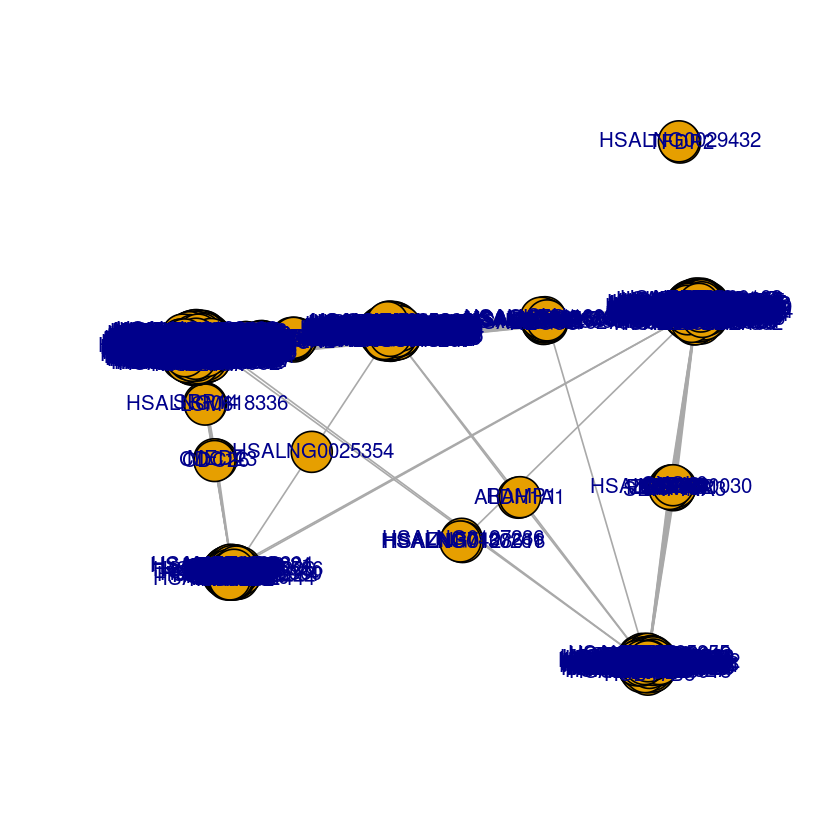

In [34]:
# 创建一个igraph对象
net_pc<-graph_from_data_frame(
   d=nt_tf_uniq_tg,
   vertices=nt_nodes,
   directed=F)


options(repr.plot.width=7, repr.plot.height=7)
plot(net_pc,
# vertex.size=degree(net_pc,mode="all"), # 设置节点的大小
vertex.label.cex=1, # 设置节点标签的字体大小
vertex.label.dist=0.1, # 设置节点标签和点的距离
# edge.color="gray50", # 设置边的颜色
# edge.arrow.size=.7, # 设置箭头的大小
# edge.curved=.2, # 设置边的弯曲程度
# layout=layout_with_lgl(net_pc) # 设置图形的布局
)


In [115]:
BP@result

,ONTOLOGY,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051592,BP,GO:0051592,response to calcium ion,4/8,147/18866,2.417423e-07,0.0001078171,4.427701e-05,JUN/FOS/FOSB/DUSP1,4
GO:0071277,BP,GO:0071277,cellular response to calcium ion,3/8,83/18866,4.525628e-06,0.0009794041,4.022099e-04,JUN/FOS/FOSB,3
GO:0051591,BP,GO:0051591,response to cAMP,3/8,94/18866,6.587920e-06,0.0009794041,4.022099e-04,FOS/FOSB/DUSP1,3
GO:0010038,BP,GO:0010038,response to metal ion,4/8,366/18866,9.171590e-06,0.0010226323,4.199623e-04,JUN/FOS/FOSB/DUSP1,4
GO:0046683,BP,GO:0046683,response to organophosphorus,3/8,134/18866,1.911679e-05,0.0014641799,6.012917e-04,FOS/FOSB/DUSP1,3
GO:0035994,BP,GO:0035994,response to muscle stretch,2/8,18/18866,2.399215e-05,0.0014641799,6.012917e-04,JUN/FOS,2
GO:0051384,BP,GO:0051384,response to glucocorticoid,3/8,147/18866,2.522295e-05,0.0014641799,6.012917e-04,FOS/FOSB/DUSP1,3
GO:0014074,BP,GO:0014074,response to purine-containing compound,3/8,149/18866,2.626332e-05,0.0014641799,6.012917e-04,FOS/FOSB/DUSP1,3
GO:0051412,BP,GO:0051412,response to corticosterone,2/8,20/18866,2.978153e-05,0.0014758403,6.060803e-04,FOS/FOSB,2


[1] "EGR1"  "ERG"   "NR5A2" "PDX1"  "SOX17" "SOX18" "ZNF22"

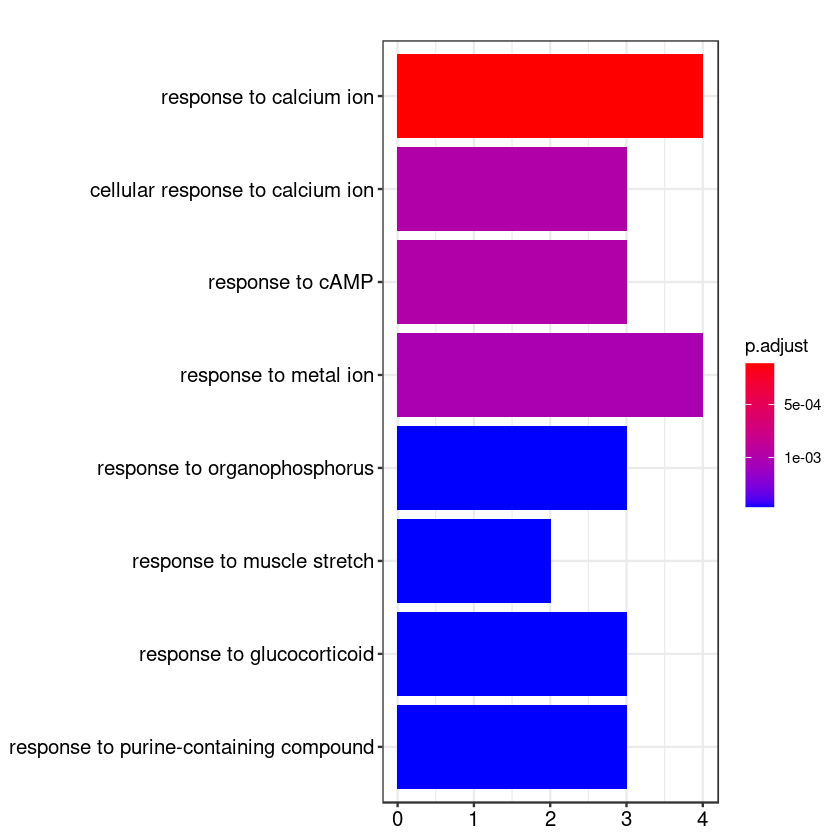

In [112]:
split(nt_tf_uniq_tg$target, nt_tf_uniq_tg$source) -> nt_tf_uniq_tg_list
nt_tf_uniq_tg_list %>% names()

# GO analysis
BP <- enrichGO(gene = nt_tf_uniq_tg_list[["EGR1"]],
                keyType ='SYMBOL',
                OrgDb = org.Hs.eg.db,
                ont = "all",
                pAdjustMethod='fdr',
                pvalueCutoff = 0.05,
                qvalueCutoff = 0.05)
barplot(BP)


In [118]:
# hallmark
hallmark <- read.gmt("/mnt/public3/chaohy/pancancer/fig4/c5.go.bp.v2023.2.Hs.symbols.gmt")

# NT
split(nt_tf_uniq_tg$target, nt_tf_uniq_tg$source) -> nt_tf_uniq_tg_list
for(i in 1:length(nt_tf_uniq_tg_list)){
    tmp <- enricher(nt_tf_uniq_tg_list[[i]], TERM2GENE = hallmark, pvalueCutoff = 1, pAdjustMethod = "BH", qvalueCutoff = 1, minGSSize = 1, maxGSSize = 500)
    tmp@result %>% as.data.frame() %>% head(2) %>% cbind(., TF=names(nt_tf_uniq_tg_list)[i]) -> tmp_df
    if(i == 1){
        tmp_df -> nt_tf_uniq_tg_hallmark
    }else{
        rbind(nt_tf_uniq_tg_hallmark, tmp_df) -> nt_tf_uniq_tg_hallmark
    }
}

# PT
split(pt_tf_uniq_tg$target, pt_tf_uniq_tg$source) -> pt_tf_uniq_tg_list
for(i in 1:length(pt_tf_uniq_tg_list)){
    tryCatch({
        tmp <- enricher(pt_tf_uniq_tg_list[[i]], TERM2GENE = hallmark, pvalueCutoff = 1, pAdjustMethod = "BH", qvalueCutoff = 1, minGSSize = 1, maxGSSize = 500)
        tmp@result %>% as.data.frame() %>% head(2) %>% cbind(., TF=names(pt_tf_uniq_tg_list)[i]) -> tmp_df
        if(i == 1){
            tmp_df -> pt_tf_uniq_tg_hallmark
        }else{
            rbind(pt_tf_uniq_tg_hallmark, tmp_df) -> pt_tf_uniq_tg_hallmark
        }
    }, error = function(e) {
    # 处理异常的代码，例如打印错误信息或其他操作
    cat("Error occurred for index", i, ":", conditionMessage(e), "\n")
})
}

# HM
split(hm_tf_uniq_tg$target, hm_tf_uniq_tg$source) -> hm_tf_uniq_tg_list
for(i in 1:length(hm_tf_uniq_tg_list)){
        tryCatch({
    tmp <- enricher(hm_tf_uniq_tg_list[[i]], TERM2GENE = hallmark, pvalueCutoff = 1, pAdjustMethod = "BH", qvalueCutoff = 1, minGSSize = 1, maxGSSize = 500)
    tmp@result %>% as.data.frame() %>% head(2) %>% cbind(., TF=names(hm_tf_uniq_tg_list)[i]) -> tmp_df
    if(i == 1){
        tmp_df -> hm_tf_uniq_tg_hallmark
    }else{
        rbind(hm_tf_uniq_tg_hallmark, tmp_df) -> hm_tf_uniq_tg_hallmark
    }
        }, error = function(e) {
    # 处理异常的代码，例如打印错误信息或其他操作
    cat("Error occurred for index", i, ":", conditionMessage(e), "\n")
})
}

--> No gene can be mapped....

--> Expected input gene ID: SNRPE,GPT2,ZFP36,KYAT3,SULT1A3,MTHFD1L

--> return NULL...



Error occurred for index 4 : trying to get slot "result" from an object of a basic class ("NULL") with no slots 


No gene set have size > 1 ...

--> return NULL...



Error occurred for index 6 : trying to get slot "result" from an object of a basic class ("NULL") with no slots 


In [119]:
nt_tf_uniq_tg_hallmark
pt_tf_uniq_tg_hallmark
hm_tf_uniq_tg_hallmark

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,TF
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GOBP_RESPONSE_TO_CORTICOSTERONE,GOBP_RESPONSE_TO_CORTICOSTERONE,GOBP_RESPONSE_TO_CORTICOSTERONE,2/8,14/17959,1.575898e-05,4.549025e-03,2.027681e-03,FOS/FOSB,2,EGR1
GOBP_REGULATION_OF_TRANSCRIPTION_FROM_RNA_POLYMERASE_II_PROMOTER_IN_RESPONSE_TO_STRESS,GOBP_REGULATION_OF_TRANSCRIPTION_FROM_RNA_POLYMERASE_II_PROMOTER_IN_RESPONSE_TO_STRESS,GOBP_REGULATION_OF_TRANSCRIPTION_FROM_RNA_POLYMERASE_II_PROMOTER_IN_RESPONSE_TO_STRESS,2/8,33/17959,9.105041e-05,4.549025e-03,2.027681e-03,JUN/ATF3,2,EGR1
GOBP_RESPONSE_TO_TRANSFORMING_GROWTH_FACTOR_BETA,GOBP_RESPONSE_TO_TRANSFORMING_GROWTH_FACTOR_BETA,GOBP_RESPONSE_TO_TRANSFORMING_GROWTH_FACTOR_BETA,9/46,297/17959,5.281541e-08,3.794762e-05,2.493967e-05,FKBP1A/SPRY1/CLDN5/TGFBR2/TGFBR3/PXN/HYAL2/ENG/CDH5,9,ERG
GOBP_VASCULOGENESIS,GOBP_VASCULOGENESIS,GOBP_VASCULOGENESIS,6/46,83/17959,6.553993e-08,3.794762e-05,2.493967e-05,EGFL7/TGFBR2/TGFBR3/TIE1/CD34/ENG,6,ERG
GOBP_DIGESTION,GOBP_DIGESTION,GOBP_DIGESTION,8/23,134/17959,3.471194e-12,1.402362e-09,9.755881e-10,CLPS/PRSS1/CTRB1/CTRB2/PRSS2/PNLIP/SERPINA3/CEL,8,NR5A2
GOBP_LIPID_CATABOLIC_PROCESS,GOBP_LIPID_CATABOLIC_PROCESS,GOBP_LIPID_CATABOLIC_PROCESS,5/23,335/17959,5.594481e-05,1.130085e-02,7.861718e-03,CLPS/INS/PNLIP/PLA2G1B/CEL,5,NR5A2
GOBP_PROTEIN_TRANSPORT_INTO_MEMBRANE_RAFT,GOBP_PROTEIN_TRANSPORT_INTO_MEMBRANE_RAFT,GOBP_PROTEIN_TRANSPORT_INTO_MEMBRANE_RAFT,1/4,5/17959,1.113276e-03,2.803346e-02,9.836303e-03,CD24,1,PDX1
GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION_INVOLVED_IN_KIDNEY_DEVELOPMENT,GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION_INVOLVED_IN_KIDNEY_DEVELOPMENT,GOBP_POSITIVE_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIATION_INVOLVED_IN_KIDNEY_DEVELOPMENT,1/4,7/17959,1.558326e-03,2.803346e-02,9.836303e-03,CD24,1,PDX1
GOBP_PEPTIDYL_TYROSINE_MODIFICATION,GOBP_PEPTIDYL_TYROSINE_MODIFICATION,GOBP_PEPTIDYL_TYROSINE_MODIFICATION,8/55,279/17959,1.985207e-06,2.707822e-03,2.049987e-03,NEDD9/SOCS3/FLT1/EHD4/HYAL2/INSR/CD36/PLPP3,8,SOX17


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,TF
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GOBP_REGULATION_OF_MIRNA_CATABOLIC_PROCESS,GOBP_REGULATION_OF_MIRNA_CATABOLIC_PROCESS,GOBP_REGULATION_OF_MIRNA_CATABOLIC_PROCESS,1/4,10/17959,2.225622e-03,2.146444e-02,3.476022e-03,TENT2,1,CTCF
GOBP_HISTONE_MRNA_CATABOLIC_PROCESS,GOBP_HISTONE_MRNA_CATABOLIC_PROCESS,GOBP_HISTONE_MRNA_CATABOLIC_PROCESS,1/4,15/17959,3.337038e-03,2.146444e-02,3.476022e-03,TENT2,1,CTCF
GOBP_RESPONSE_TO_MOLECULE_OF_BACTERIAL_ORIGIN,GOBP_RESPONSE_TO_MOLECULE_OF_BACTERIAL_ORIGIN,GOBP_RESPONSE_TO_MOLECULE_OF_BACTERIAL_ORIGIN,22/151,369/17959,5.617974e-13,1.502246e-09,1.143110e-09,SOD2/PTGS2/CXCL8/NFKBIZ/S100A8/TRIB1/S100A9/LITAF/CD55/IL1B/MAP2K3/NFKBIA/FOS/CSF2RB/ZFP36/PDE4B/LYN/ABCA1/PF4/SBNO2/ADM/PPBP,22,EGR3
GOBP_NEUTROPHIL_CHEMOTAXIS,GOBP_NEUTROPHIL_CHEMOTAXIS,GOBP_NEUTROPHIL_CHEMOTAXIS,12/151,106/17959,8.967438e-11,8.282979e-08,6.302798e-08,CXCL8/S100A8/S100A9/IL1B/CSF3R/CXCR2/TNFAIP6/S100A12/PDE4B/PF4/PPBP/CXCR1,12,EGR3
GOBP_TYPE_I_PNEUMOCYTE_DIFFERENTIATION,GOBP_TYPE_I_PNEUMOCYTE_DIFFERENTIATION,GOBP_TYPE_I_PNEUMOCYTE_DIFFERENTIATION,2/33,8/17959,9.105041e-05,3.939412e-02,2.903731e-02,KRAS/KLF2,2,KLF3
GOBP_RESPONSE_TO_TUMOR_NECROSIS_FACTOR,GOBP_RESPONSE_TO_TUMOR_NECROSIS_FACTOR,GOBP_RESPONSE_TO_TUMOR_NECROSIS_FACTOR,5/33,258/17959,1.005318e-04,3.939412e-02,2.903731e-02,ERBIN/RELA/ADAM10/KLF2/UBE2K,5,KLF3
GOBP_NEGATIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION,GOBP_NEGATIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION,GOBP_NEGATIVE_REGULATION_OF_ACTIVATED_T_CELL_PROLIFERATION,1/1,15/17959,8.352358e-04,1.670472e-02,NA,PDCD1LG2,1,SP3
GOBP_NEGATIVE_REGULATION_OF_INTERLEUKIN_10_PRODUCTION,GOBP_NEGATIVE_REGULATION_OF_INTERLEUKIN_10_PRODUCTION,GOBP_NEGATIVE_REGULATION_OF_INTERLEUKIN_10_PRODUCTION,1/1,24/17959,1.336377e-03,1.670472e-02,NA,PDCD1LG2,1,SP3


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,TF
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
GOBP_DNA_REPLICATION,GOBP_DNA_REPLICATION,GOBP_DNA_REPLICATION,44/88,279/17959,1.141729e-56,8.916901e-54,6.021117e-54,CDT1/GINS2/MCM4/MCM2/DTL/PCLAF/FEN1/FAM111B/CDC6/PCNA/TK1/CDC45/CHEK1/ORC6/RAD51/MCM7/MCM3/RRM2/MCM10/CHAF1A/BRCA1/WDHD1/MCM6/ATAD5/RFC4/GINS1/ESCO2/RFC2/MCM5/E2F8/RRM1/BRCA2/DSCC1/RMI2/CCNE1/TIMELESS/RECQL4/CCNE2/DUT/POLD1/MCM8/TIPIN/RPA3/E2F7,44,E2F1
GOBP_DNA_TEMPLATED_DNA_REPLICATION,GOBP_DNA_TEMPLATED_DNA_REPLICATION,GOBP_DNA_TEMPLATED_DNA_REPLICATION,34/88,162/17959,1.389888e-47,5.427511e-45,3.664914e-45,CDT1/GINS2/MCM4/MCM2/FEN1/CDC6/PCNA/TK1/CDC45/ORC6/RAD51/MCM7/MCM3/MCM10/BRCA1/WDHD1/MCM6/ATAD5/RFC4/GINS1/RFC2/MCM5/E2F8/RRM1/BRCA2/DSCC1/CCNE1/TIMELESS/RECQL4/CCNE2/POLD1/MCM8/TIPIN/E2F7,34,E2F1
GOBP_G_PROTEIN_COUPLED_PURINERGIC_RECEPTOR_SIGNALING_PATHWAY,GOBP_G_PROTEIN_COUPLED_PURINERGIC_RECEPTOR_SIGNALING_PATHWAY,GOBP_G_PROTEIN_COUPLED_PURINERGIC_RECEPTOR_SIGNALING_PATHWAY,1/1,12/17959,6.681887e-04,6.514839e-03,NA,ADORA3,1,ETV5
GOBP_REGULATION_OF_NOREPINEPHRINE_SECRETION,GOBP_REGULATION_OF_NOREPINEPHRINE_SECRETION,GOBP_REGULATION_OF_NOREPINEPHRINE_SECRETION,1/1,13/17959,7.238710e-04,6.514839e-03,NA,ADORA3,1,ETV5
GOBP_FAS_SIGNALING_PATHWAY,GOBP_FAS_SIGNALING_PATHWAY,GOBP_FAS_SIGNALING_PATHWAY,1/3,8/17959,1.335856e-03,4.439612e-02,1.335222e-02,CASP8AP2,1,KLF12
GOBP_POSITIVE_REGULATION_OF_METAPHASE_ANAPHASE_TRANSITION_OF_CELL_CYCLE,GOBP_POSITIVE_REGULATION_OF_METAPHASE_ANAPHASE_TRANSITION_OF_CELL_CYCLE,GOBP_POSITIVE_REGULATION_OF_METAPHASE_ANAPHASE_TRANSITION_OF_CELL_CYCLE,1/3,15/17959,2.503754e-03,4.439612e-02,1.335222e-02,ANAPC5,1,KLF12
GOBP_T_CELL_DIFFERENTIATION,GOBP_T_CELL_DIFFERENTIATION,GOBP_T_CELL_DIFFERENTIATION,17/68,307/17959,1.196492e-15,1.693036e-12,1.243092e-12,IL7R/BATF/CCR6/TCF7/FOXP3/CTLA4/BCL11B/CD28/STAT4/RORA/GATA3/CAMK4/CD3D/ZFP36L2/ITK/CD3G/IL23A,17,PBX4
GOBP_MONONUCLEAR_CELL_DIFFERENTIATION,GOBP_MONONUCLEAR_CELL_DIFFERENTIATION,GOBP_MONONUCLEAR_CELL_DIFFERENTIATION,19/68,482/17959,9.811812e-15,6.941857e-12,5.096978e-12,IL7R/BATF/CCR6/TCF7/FOXP3/CTLA4/BCL11B/CD28/SLAMF1/STAT4/RORA/GATA3/CD40LG/CAMK4/CD3D/ZFP36L2/ITK/CD3G/IL23A,19,PBX4


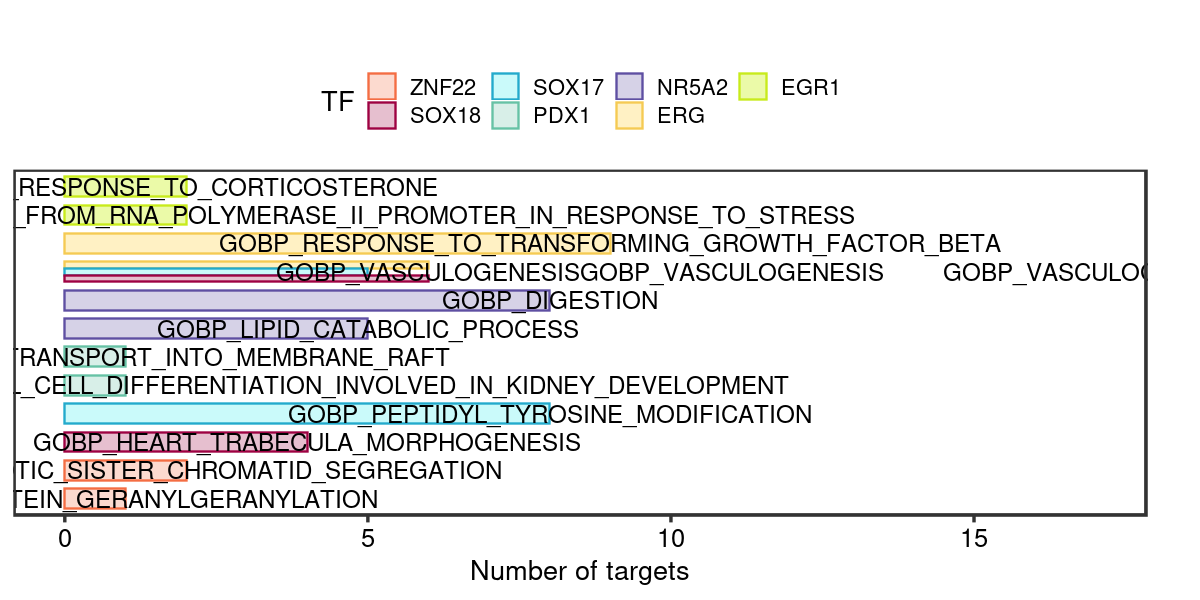

In [191]:
options(repr.plot.width=10, repr.plot.height=5)
nt_tf_uniq_tg_hallmark$Description <- factor(nt_tf_uniq_tg_hallmark$Description, levels = rev(unique(nt_tf_uniq_tg_hallmark$Description)))
ggplot(nt_tf_uniq_tg_hallmark, aes(x = Count, y = Description, fill=TF,color=TF)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = Description), position = position_stack(1), size = 5, color="black") +
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "Number of targets", y = "", title = "") +
  guides(size = FALSE) +
  theme(axis.text = element_text(size = 15, color = "black"),
        # axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        # axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank(),
        legend.position="top")+
    scale_fill_manual(values = c("#fcdacf", "#e6bfcf", "#cafafa", "#d8efe8", "#d6d2e7", "#fff1c4", "#ebfaa8")) +
    scale_color_manual(values = c("#f46d43", "#9e0142", "#23aacc", "#66c2a5", "#5e4fa2", "#f5ca53", "#c8eb1b"))  -> p1
p1

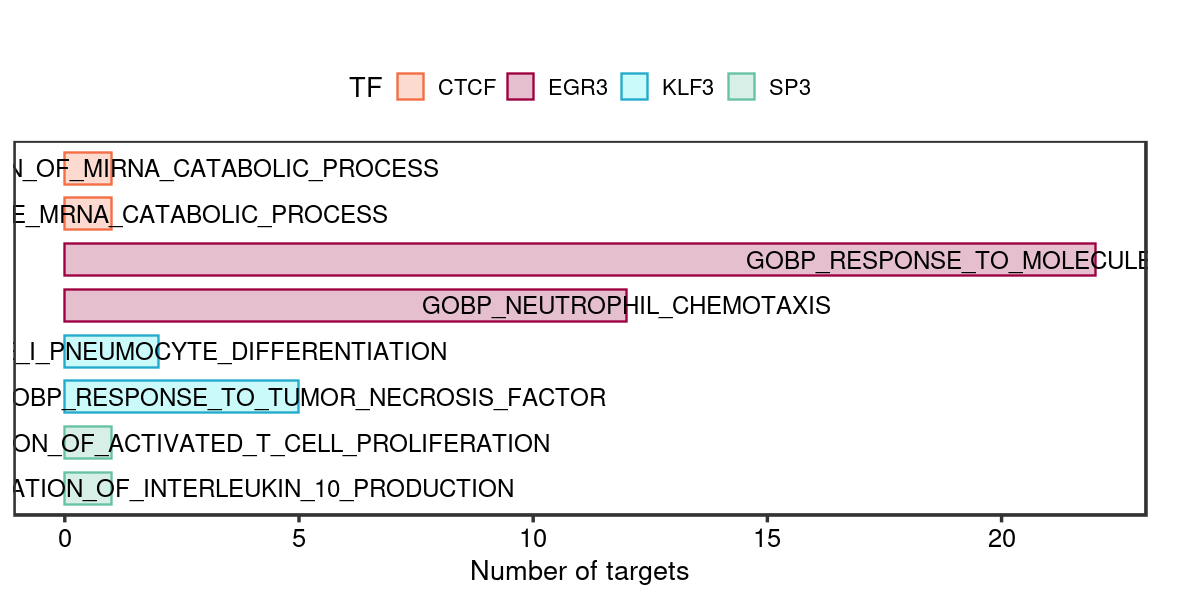

In [196]:
options(repr.plot.width=10, repr.plot.height=5)
pt_tf_uniq_tg_hallmark$Description <- factor(pt_tf_uniq_tg_hallmark$Description, levels = rev(unique(pt_tf_uniq_tg_hallmark$Description)))
ggplot(pt_tf_uniq_tg_hallmark, aes(x = Count, y = Description, fill=TF,color=TF)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = Description), position = position_stack(1), size = 5, color="black") +
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "Number of targets", y = "", title = "") +
  guides(size = FALSE) +
  theme(axis.text = element_text(size = 15, color = "black"),
        # axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        # axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank(),
        legend.position="top")+
    scale_fill_manual(values = c("#fcdacf", "#e6bfcf", "#cafafa", "#d8efe8", "#d6d2e7", "#fff1c4", "#ebfaa8")) +
    scale_color_manual(values = c("#f46d43", "#9e0142", "#23aacc", "#66c2a5", "#5e4fa2", "#f5ca53", "#c8eb1b"))  -> p2
p2

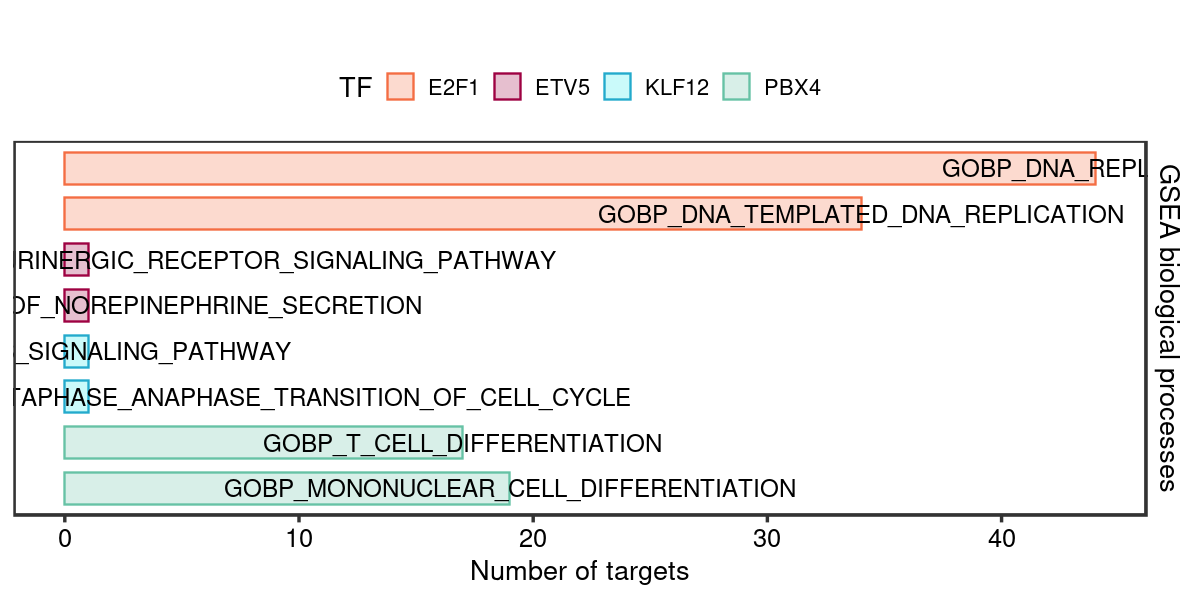

In [184]:
options(repr.plot.width=10, repr.plot.height=5)
hm_tf_uniq_tg_hallmark$Description <- factor(hm_tf_uniq_tg_hallmark$Description, levels = rev(unique(hm_tf_uniq_tg_hallmark$Description)))
ggplot(hm_tf_uniq_tg_hallmark, aes(x = Count, y = Description, fill=TF,color=TF)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = Description), position = position_stack(1), size = 5, color="black") +
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "Number of targets", y = "GSEA biological processes", title = "") +
  guides(size = FALSE) +
  theme(axis.text = element_text(size = 15, color = "black"),
        # axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        # axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank(),
        legend.position="top")+
    scale_fill_manual(values = c("#fcdacf", "#e6bfcf", "#cafafa", "#d8efe8", "#d6d2e7", "#fff1c4", "#ebfaa8")) +
    scale_color_manual(values = c("#f46d43", "#9e0142", "#23aacc", "#66c2a5", "#5e4fa2", "#f5ca53", "#c8eb1b"))  -> p3
p3

png 
  2

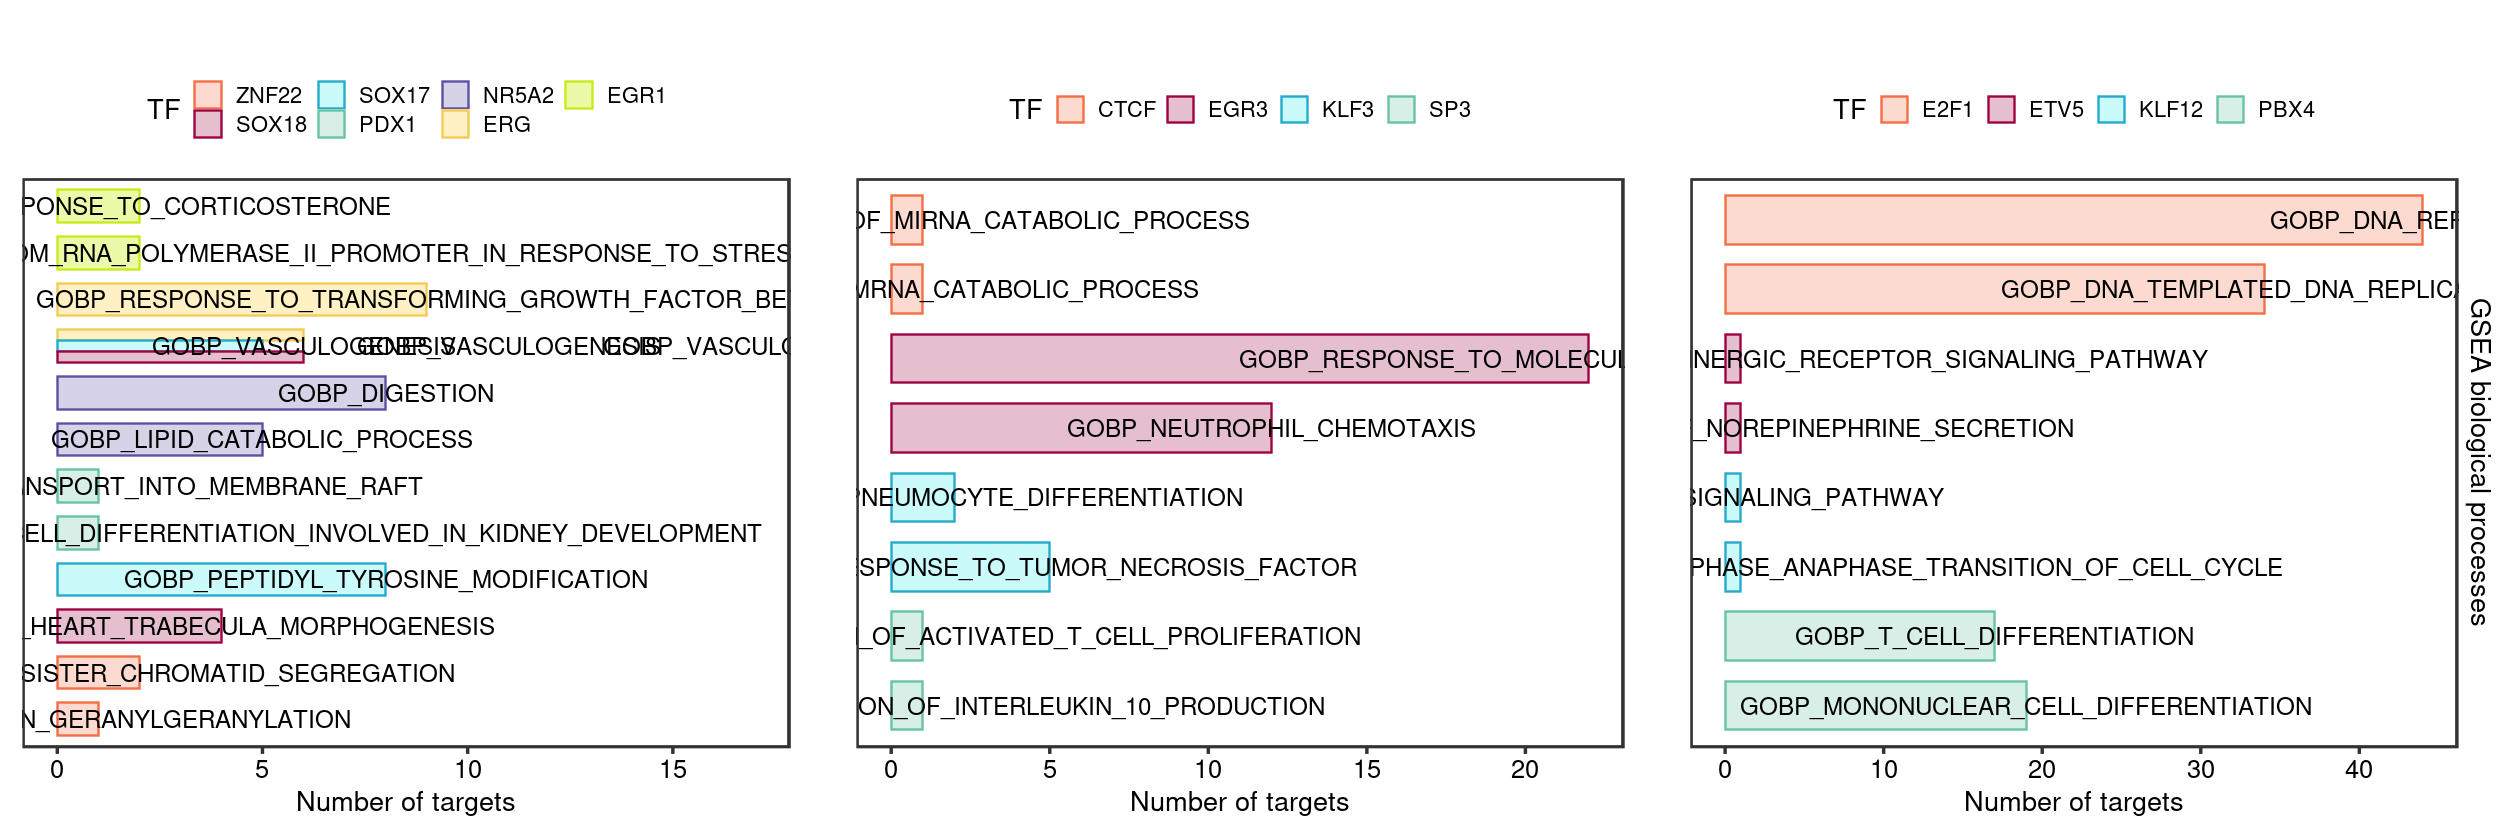

In [197]:
options(repr.plot.width=21, repr.plot.height=7)
(p1 + p2 + p3) + plot_layout(nrow = 1)

pdf("/mnt/public3/chaohy/pancancer/fig4/fig4g.pdf", width = 21, height = 7)
(p1 + p2 + p3) + plot_layout(nrow = 1)
dev.off()